In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.cross_validation import train_test_split
import model
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
from model import AttentionSentRNN, AttentionWordRNN

In [4]:
word_attn = AttentionWordRNN(batch_size=64, num_tokens=81132, embed_size=300, 
                             word_gru_hidden=100, bidirectional= True)

In [5]:
sent_attn = AttentionSentRNN(batch_size=64, sent_gru_hidden=100, word_gru_hidden=100, 
                             n_classes=10, bidirectional= True)

In [6]:
learning_rate = 1e-3
word_optmizer = torch.optim.Adam(word_attn.parameters(), lr=learning_rate)
sent_optimizer = torch.optim.Adam(sent_attn.parameters(), lr=learning_rate)

In [7]:
def train_data(mini_batch, targets, word_attn_model, sent_attn_model, word_optimizer, sent_optimizer, criterion):
    state_word = word_attn_model.init_hidden().cuda()
    state_sent = sent_attn_model.init_hidden().cuda()
#     print state_sent.size()
    max_sents, batch_size, max_tokens = mini_batch.size()
    word_optimizer.zero_grad()
    sent_optimizer.zero_grad()
    s = None
    for i in xrange(max_sents):
        _s, state_word = word_attn_model(mini_batch[i,:,:].transpose(0,1), state_word)
        if(s is None):
            s = _s
        else:
            s = torch.cat((s,_s),0)
#     print s.size()
            
    y_pred, state_sent = sent_attn_model(s, state_sent)
    loss = criterion(y_pred.cuda(), targets) 
    loss.backward()
    
    word_optimizer.step()
    sent_optimizer.step()
    
    return loss.data[0]

In [8]:
criterion = nn.NLLLoss()

In [9]:
word_attn.cuda()
sent_attn.cuda()

AttentionSentRNN (
  (sent_gru): GRU(200, 100, bidirectional=True)
  (final_linear): Linear (200 -> 10)
  (softmax_sent): Softmax ()
  (final_softmax): Softmax ()
)

In [11]:
d = pd.read_json('/data1/sandeep/datasets/imdb_final.json')

In [12]:
d['rating'] = d['rating'] - 1

In [13]:
d.head()

,cleaned_sent,rating,review,sentences,tokens,url,user
0,"[i excepted a lot from this movie , and it did...",9,"i excepted a lot from this movie , and it did ...","[i excepted a lot from this movie , and it did...","[[18, 26739, 10, 166, 47, 19, 31, 6, 9, 15, 97...",\tt0119485,ur2480402/
1,"[this movie is not worth seeing . , has no me...",0,this movie is not worth seeing . <sssss> has n...,"[this movie is not worth seeing . , has no me...","[[19, 31, 13, 37, 331, 343, 8], [3, 49, 94, 51...",\tt0109836,ur2480402/
10,"[this is a great movie ! , it is so funny . ,...",9,this is a great movie ! <sssss> it is so funny...,"[this is a great movie ! , it is so funny . ,...","[[19, 13, 10, 88, 31, 77], [3, 15, 13, 53, 192...",\tt0088011,ur2480402/
100,[there 's a kid in this film that concerns me ...,5,there 's a kid in this film that concerns me ....,[there 's a kid in this film that concerns me ...,"[[52, 17, 10, 692, 14, 19, 24, 16, 3177, 106, ...",\tt0762114,ur4751428/
1000,[john hall -lrb- david andrews -rrb- is a drif...,7,john hall -lrb- david andrews -rrb- is a drift...,[john hall -lrb- david andrews -rrb- is a drif...,"[[221, 2210, 27, 460, 4447, 26, 13, 10, 9737, ...",\tt0099697,ur5115203/


In [14]:
train, test = train_test_split(d, test_size = 0.3, random_state= 42)

In [15]:
train.shape

(59443, 7)

In [16]:
def gen_minibatch(df, mini_batch_size):
    random_batch = np.random.randint(0,df.shape[0],mini_batch_size)
    labels = df.rating.iloc[random_batch].values
    tokens = df.tokens.iloc[random_batch].values
    max_sent_len = int(np.mean([len(x) for x in tokens]))
#     print max_sent_len
    max_token_len = int(np.mean([len(val) for sublist in tokens for val in sublist]))
#     print max_token_len
    main_matrix = np.zeros((mini_batch_size, max_sent_len, max_token_len), dtype= np.int)
    # must be a better way to do this
    for i in xrange(main_matrix.shape[0]):
        for j in xrange(main_matrix.shape[1]):
            for k in xrange(main_matrix.shape[2]):
                try:
                    main_matrix[i,j,k] = tokens[i][j][k]
                except IndexError:
                    pass
    return Variable(torch.from_numpy(main_matrix).transpose(0,1)), Variable(torch.from_numpy(labels), requires_grad= False)

In [ ]:
loss_full = []
loss_smooth = []
counter = 0
for i in xrange(7000):
    tokens, labels = gen_minibatch(train, 64)
    loss = train_data(tokens.cuda(), labels.cuda(), word_attn, sent_attn, word_optmizer, sent_optimizer, criterion)
    loss_full.append(loss)
    loss_smooth.append(loss)
    counter += 1
    if counter == 29:
        print 'Loss after %d minibatches is %f' % (i, np.mean(loss_smooth))
        loss_smooth = []
        counter = 0

Loss after 28 minibatches is 2.160573
Loss after 57 minibatches is 2.116110
Loss after 86 minibatches is 2.110283
Loss after 115 minibatches is 2.078117
Loss after 144 minibatches is 2.048646


In [32]:
plt.style.use('seaborn-dark-palette')
from pylab import rcParams
rcParams['figure.figsize'] = 12, 8

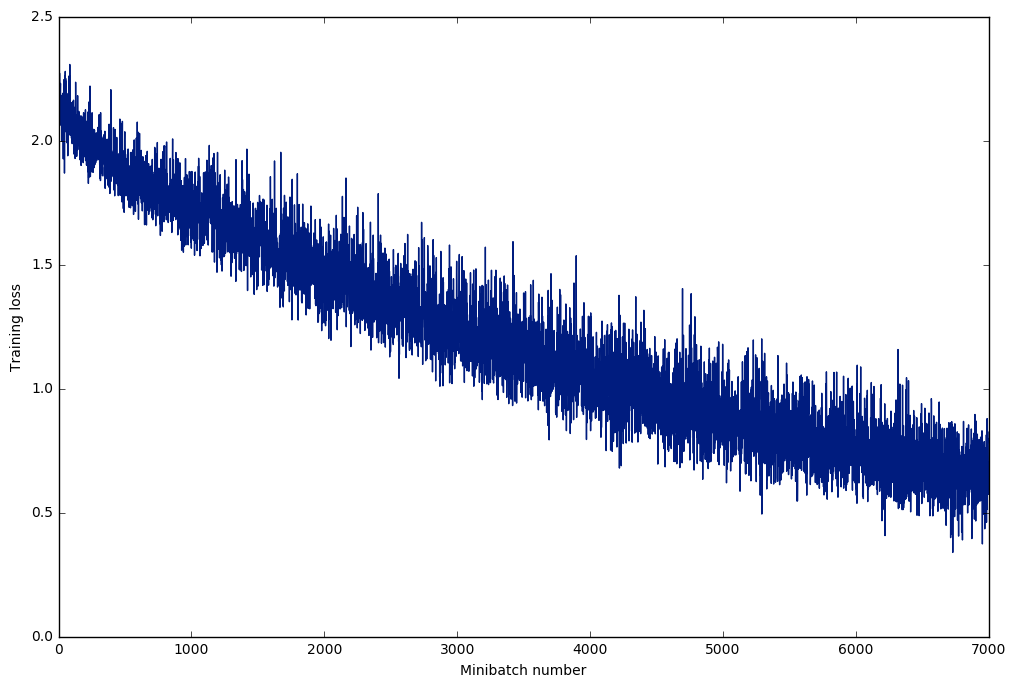

In [33]:
plt.plot(loss_full)
plt.xlabel('Minibatch number')
plt.ylabel('Training loss')